In [3]:
import ee
import geemap
import numpy as np
import time
import pandas as pd
from ipygee import *
import matplotlib.pyplot as plt


#ee.Authenticate()
ee.Initialize()

dataset = 'Meuse_Catchment_4326'
crs = 'EPSG:4326'
fignum = 0
RGB_VIS = {'bands':['B3','B2','B1'], 'min':0, 'max':3000}

In [4]:
# Import the table of geometries

table = ee.FeatureCollection(f"projects/mohanrahan/assets/{dataset}")

def set_area_m2(feature):
    area = feature.geometry().area()
    setting = feature.set('area_m2', area)
    return setting

table_area = table.map(set_area_m2)

Filtered_Sorted = table_area.filter(ee.Filter.gt('area_m2', 50e6)).sort('area_m2', True)

area_reduced = Filtered_Sorted.reduceToImage(['area_m2'],'mean')

geom = Filtered_Sorted.first().geometry()

start_year = 1984 #TODO - user input
end_year = 2021 #TODO - user input
start_day = '06-20' #TODO - user input
end_day = '12-31' #TODO - user input
aoi = geom
dsnr_threshold = 2.0 #TODO - user input? What is this?
mask_these = ['cloud', 'shadow', 'snow', 'water'] #TODO - user input? 

#only one of these should be used at a time. Comment out the other one.
index = 'NDVI'  #TODO - user input
# index = 'NBR'

ftv_list = [
    'NDVI', # normalized diff vegetation index
#    'NBR', # normalized burn ratio
    'B4', # LS band 4, red
    'B5', # LS band 5, near-infrared
]

scale = 100 #output reduction scale in meters

landtrendr_run_params = { #TODO - user input
    "maxSegments": 6,
    "spikeThreshold": 0.9,
    "vertexCountOvershoot": 3,
    "preventOneYearRecovery": True,
    "recoveryThreshold": 0.25,
    "pvalThreshold": 0.05,
    "bestModelProportion": 0.75,
    "minObservationsNeeded": 6
}

sys_index = Filtered_Sorted.aggregate_array('system:index').getInfo()
ind = sys_index[0]
feature = Filtered_Sorted.filter(ee.Filter.eq('system:index', ind))
filtered_table = feature.getInfo()

aoi = feature.geometry()

print(f'-- sys_indices (sorted by column: area_m2 > 50e6 , H-->L): {len(sys_index)} indices -- \n \n{sys_index}\n')
print(f'-- first_index: -- \n \n{ind}\n')
print(f'-- filtered_table: -- \n \n{filtered_table["columns"]}\n')


-- sys_indices (sorted by column: area_m2 > 50e6 , H-->L): 36 indices -- 
 
['00000000000000000007', '0000000000000000001c', '00000000000000000009', '0000000000000000000c', '0000000000000000001b', '0000000000000000001d', '0000000000000000000d', '00000000000000000018', '00000000000000000024', '00000000000000000008', '00000000000000000013', '00000000000000000017', '0000000000000000001e', '00000000000000000002', '00000000000000000010', '00000000000000000026', '0000000000000000001a', '0000000000000000002b', '00000000000000000016', '0000000000000000002a', '00000000000000000023', '00000000000000000029', '00000000000000000015', '00000000000000000003', '00000000000000000011', '00000000000000000019', '0000000000000000000f', '00000000000000000025', '0000000000000000000a', '00000000000000000014', '00000000000000000028', '00000000000000000027', '00000000000000000004', '00000000000000000020', '00000000000000000012', '00000000000000000005']

-- first_index: -- 
 
00000000000000000007

-- filtered_ta

In [5]:
gdf = geemap.ee_to_pandas(table_area)
gdf.keys()

Index(['area_m2', '_Siltsum', '_Sandmean', '_Claysum', 'area2', 'DN',
       '_Catchme_2', '_Catchme_1', '_Sandcount', '_Sandsum', '_Catchment',
       '_Siltcount', '_Siltmean', 'area', '_Soil_poro', '_Soil_po_3',
       '_Claycount', '_Areacount', '_Areamean', '_Soil_po_1', '_Soil_po_2',
       '_Slopecoun', '_Slopeme_1', '_Claymean', '_Slopesum', '_Areasum',
       '_Slopemean'],
      dtype='object')

In [5]:
gdf_sorted = gdf.sort_values('area_m2', ascending=False)
index_names = gdf[ (gdf['area_m2'] < 50e6)].index
gdf_sorted.drop(index_names, inplace=True)
gdf_sorted['GEE_id'] =sys_index

#gdf_sorted.to_excel('catchment_table_w_GEE_ID.xlsx')

In [6]:
aoi.centroid().getInfo()['coordinates']

[5.252806723646078, 50.390241997964694]

In [7]:
Map = geemap.Map()

Map.centerObject(aoi, 10)

for ind in sys_index:
    aoi = Filtered_Sorted.filter(ee.Filter.eq('system:index', ind))
    Map.addLayer(aoi, {}, index[18:])
    
    print(f'index: {ind}')
    
    if ind == '00000000000000000007':
        break
    
    #if ind == '00000000000000000005':
    #    break

Map

index: 00000000000000000007


Map(center=[50.390241997964694, 5.252806723646078], controls=(WidgetControl(options=['position', 'transparent_…

In [15]:
# -*- coding: utf-8 -*-
"""gee_deforestation.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1AgeHoMcokPDVfFE81QGs1SKeEAgXsBci

## Overview
The goal of this notebook is to implement a python version of the JavaScript code [here](https://code.earthengine.google.com/73dcaa2cae2e4aad2da593ec6ab1af85), making use of python utility code available via the Earthshot Labs Forest repo. 

## Caveat about GEE utility code
This notebook uses code copied from [Github](https://github.com/earthshot-labs/forest/blob/main/earth-engine/landtrendr/preprocess.py) which should be assembled into a package (e.g. earthshot) and installed via pip instead. For now, we'll just copy the code over, though.
"""

## Code from preprocess.py

from typing import List

INDEX_DICT = {
    "NDVI": {"dist_dir": -1, "bands": ["B4", "B3"]},
    "NBR": {"dist_dir": -1, "bands": ["B4", "B7"]},
}


def _extract_and_append_date(image: ee.Image, input_list: ee.List) -> ee.List:
    """Given an ee.Image and an ee.List, append the image's date to the list."""
    date = image.date()
    return ee.List(input_list).add(ee.Date(date))


def _create_yearly_list(collection: ee.ImageCollection) -> ee.List:
    """Given an ee.ImageCollection, return an ee.List containing all the (unique)
    years present in the collection."""
    dates = collection.iterate(_extract_and_append_date, ee.List([]))

    years = ee.List(dates).map(lambda date: ee.Date(date).get("year")).distinct().sort()

    return years


def _extract_medoid_image(
    year: int,
    collection: ee.ImageCollection,
    start_day: str = start_day,
    end_day: str = end_day,
) -> ee.Image:
    """Given a year of interest, an ee.ImageCollection, and boundaries of start
    and end days, return an ee.Image which is the medoid image for the year in
    question. Distance calculated using the standard Euclidean norm across all
    6 TM-equivalent bands. Question: is it possible to do better, for the purposes
    of a deforestation analysis, by applying a higher weight to NIR and SWIR bands?
    Parameters
    ----------
    year: int
      The year for which the medoid should be calculated.
    collection: ee.ImageCollection[]
      The collection whose medoid should be calculated.
    start_day: str
      The first day, inclusive, to consider in calculating the medoid. Formatted
      as 'mm-dd'.
    end_day: str
      The last day, inclusive, to consider in calculating the medoid. Formatted as
      'mm-dd'.
    Returns
    -------
    ee.Image
      An ee.Image containing the pixel-wise medoid for the year in question.
    """
    start_m, start_d = start_day.split("-")
    end_m, end_d = end_day.split("-")

    start_date = ee.Date.fromYMD(ee.Number(year), int(start_m), int(start_d))
    end_date = ee.Date.fromYMD(ee.Number(year), int(end_m), int(end_d)).advance(
        1, "day"
    )
    filtered_collection = collection.filterDate(start_date, end_date)
    empty_col = ee.ImageCollection([ee.Image([0,0,0,0,0,0]).mask(ee.Image(0))]);
    non_empty = filtered_collection.toList(1).length().gt(0)
    final_collection = ee.ImageCollection(ee.Algorithms.If(non_empty, filtered_collection, empty_col))
    median = final_collection.median()

    def _euclidean_distance(image: ee.Image) -> ee.Image:
        distance = ee.Image(image).subtract(median).pow(ee.Image.constant(2))
        return distance.reduce("sum").addBands(image)

    distance_from_median = final_collection.map(_euclidean_distance)
    return (
        ee.ImageCollection(distance_from_median)
        .reduce(ee.Reducer.min(7))
        .set("system:time_start", ee.Date.fromYMD(year, 8, 1).millis())
    )


def _generate_medoid_collection(
    collection: ee.ImageCollection, start_day: str, end_day: str
) -> ee.ImageCollection:
    """Given an ee.ImageCollection and bounds on the start and end days, compute
    an ee.ImageCollection which contains a medoid image for each year present in
    the input collection.
    Parameters
    ----------
    collection: ee.ImageCollection
      The collection whose medoid should be calculated.
    start_day: str
      The first day, inclusive, to consider in calculating the medoid. Formatted
      as 'mm-dd'.
    end_day: str
      The last day, inclusive, to consider in calculating the medoid. Formatted as
      'mm-dd'.
    Returns
    -------
    ee.ImageCollection
      A collection of yearly medoid images for the provided collection.
    """

    years = _create_yearly_list(collection)

    def _extract_medoid(year):
        return _extract_medoid_image(year, collection, start_day, end_day)

    images = years.map(_extract_medoid)
    return ee.ImageCollection.fromImages(images)


def _mask_landsat_sr(image: ee.Image) -> ee.Image:
    """Apply a mask to a Landsat image to filter out water, cloud, snow, and cloud
    shadow pixels. TODO: update to collection 2
    
    Bitmask for QA_PIXEL
    Bit 0: Fill
    Bit 1: Dilated Cloud
    Bit 2: Unused
    Bit 3: Cloud
    Bit 4: Cloud Shadow
    Bit 5: Snow
    Bit 6: Clear
        0: Cloud or Dilated Cloud bits are set
        1: Cloud and Dilated Cloud bits are not set
    Bit 7: Water
    Bits 8-9: Cloud Confidence
        0: None
        1: Low
        2: Medium
        3: High
    Bits 10-11: Cloud Shadow Confidence
        0: None
        1: Low
        2: Medium
        3: High
    Bits 12-13: Snow/Ice Confidence
        0: None
        1: Low
        2: Medium
        3: High
    Bits 14-15: Cirrus Confidence
        0: None
        1: Low
        2: Medium
        3: High
    """
    qa_band = image.select("QA_PIXEL")
    # Bits 2, 3, 4, and 5 of pixel_qa band of Landsat are water, cloud shadow, snow,
    # and cloud, respectively. Define bitmasks for these entries below:
    
    
    dilated_cloud = 1 << 1
    cloud_bit_msk = 1 << 3
    cloud_shadow_bit_msk = 1 << 4
    snow_bit_msk = 1 << 5
    water_bit_msk = 1 << 7

    qa_mask = (
        qa_band.bitwiseAnd(cloud_bit_msk).eq(0)
        .And(qa_band.bitwiseAnd(cloud_shadow_bit_msk).eq(0))
        .And(qa_band.bitwiseAnd(dilated_cloud).eq(0))
        .And(qa_band.bitwiseAnd(snow_bit_msk).eq(0))
        .And(qa_band.bitwiseAnd(water_bit_msk).eq(0))
    )

    return image.updateMask(qa_mask)


def _prepare_images(
    image: ee.Image, input_bands: List[str], output_bands: List[str]
) -> ee.Image:
    """Takes an ee.Image object and a list of input and output bands; this function
    resamples the image using bilinear resampling, applies a QA mask, and returns
    an ee.Image with the output bands selected and with the system:time_start
    field set from input image.
    Intended to be used via partial execution for TM and OLI collections.
    Parameters
    ----------
    image: ee.Image
      The image to prepare.
    input_bands: List[str]
      The bands to select from the image.
    output_bands: List[str]
      The labels for the selected bands in the output image.
    Returns
    -------
    ee.Image
      The input image, resampled, with QA mask applied, and with bands renamed.
    """

    resampled_image = image.resample("bilinear").set(
        "system:time_start", image.get("system:time_start")
    )

    return _mask_landsat_sr(resampled_image).select(input_bands, output_bands)

def _applyScaleFactors_TM(image: ee.Image)-> ee.Image:
    """
    This adapts/updates the old earthshot code to make use of the newer Collection 2 landsat data. This is applied to the L7 ETM+ and 
    1. bands must be scaled by this function
    2. must adapt code to use the "SR_..." naming convention
    3. divide by 100 in collection 2 to reduce the scale 
    """
    opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2).divide(100) 
   # thermalBand = image.select('ST_B6').multiply(0.00341802).add(149.0)
    return image.addBands(opticalBands)#.addBands(thermalBand)

def _build_TM_collection(
    sensor: str,
    aoi: ee.Geometry,
    start_year: int = start_year,
    start_day: int = start_day,
    end_year: int = end_year,
    end_day: int = end_day,
) -> ee.ImageCollection:
    """Given the sensor, area of interest, and date boundaries, return a collection
    of TM (or ETM+) Landsat images. Intended for use on Landsat 5 and Landsat 7
    images.
    Parameters
    ----------
    sensor: str
      The sensor to use -- expects one of 'LT05' or 'LE07'.
    aoi: ee.Geometry
      The area of interest for the collection. This will be used in a filterBounds
      call on the collection to reduce size.
    start_year: int
      The first year (inclusive) to get data.
    start_day: str
      The first day (inclusive) to get data. Formatted as 'mm-dd'.
    end_year: int
      The last year (inclusive) to get data.
    end_day: str
      The last day (inclusive) to get data. Formatted as 'mm-dd'.
    Returns
    -------
    ee.ImageCollection
      The filtered collection.
    """

    def _prepare_TM(image: ee.Image) -> ee.Image:
        return _prepare_images(
            image=image,
            input_bands=["SR_B1", "SR_B2", "SR_B3", "SR_B4", "SR_B5", "SR_B7"],
            output_bands=["B1", "B2", "B3", "B4", "B5", "B7"],
        )

    collection = (
        ee.ImageCollection("LANDSAT/" + sensor + "/C02/T1_L2") #LT05/C02/T1_L2
        .filterBounds(aoi)
        .filterDate(
            ee.Date(str(start_year) + "-" + start_day),
            ee.Date(str(end_year) + "-" + end_day).advance(1, "day"),
        )
    )
    return collection.map(_applyScaleFactors_TM).map(_prepare_TM)


def _build_OLI_collection(
    sensor: str,
    aoi: ee.Geometry,
    start_year: int = start_year,
    start_day: int = start_day,
    end_year: int = end_year,
    end_day: int = end_day,
) -> ee.ImageCollection:
    """Given the sensor, area of interest, and date boundaries, return a collection
    of TM-equivalent Landsat images from an OLI Landsat collection. Intended for
    use on Landsat 8 images.
    This function applies a linear transformation to harmonize Landsat 7 (ETM) and
    Landsat 8 (OLI) images. Transformation developed by Roy et al. and implemented
    by Justin Braaten at:
    https://github.com/eMapR/LT-GEE/blob/master/scripts/python/lt_gee_bap_test.py#L60
    Parameters
    ----------
    sensor: str
      The sensor to use -- expects 'LC08'.
    aoi: ee.Geometry
      The area of interest for the collection. This will be used in a filterBounds
      call on the collection to reduce size.
    start_year: int
      The first year (inclusive) to get data.
    start_day: str
      The first day (inclusive) to get data. Formatted as 'mm-dd'.
    end_year: int
      The last year (inclusive) to get data.
    end_day: str
      The last day (inclusive) to get data. Formatted as 'mm-dd'.
    Returns
    -------
    ee.ImageCollection
      The filtered collection with OLI bands scaled and renamed to TM-equivalents.
    """

    #def _harmonization_Roy(image: ee.Image) -> ee.Image:
    #    """Taken verbatim from Justin Braaten's implementation at:
    #    https://github.com/eMapR/LT-GEE/blob/b0e92a0c198bdd1a794e1e9b8f4db8fc7fa06054/scripts/python/lt_gee_bap_test.py#L60"""
     #   slopes = ee.Image.constant([0.9785, 0.9542, 0.9825, 1.0073, 1.0171, 0.9949])
     #   intercepts = ee.Image.constant([-0.0095, -0.0016, -0.0022, -0.0021, -0.0030, 0.0029])

     #   return (
     #       image.subtract(intercepts.multiply(10000))
     #       .divide(slopes)
     #       .toShort()
     #       .set("system:time_start", image.get("system:time_start"))
     #   )

    def _prepare_OLI(image: ee.Image) -> ee.Image:
        return _prepare_images(
            image=image,
            input_bands=["SR_B2", "SR_B3", "SR_B4", "SR_B5", "SR_B6", "SR_B7"],
            output_bands=["B1", "B2", "B3", "B4", "B5", "B7"],
        )

    collection = (
        ee.ImageCollection("LANDSAT/" + sensor + "/C02/T1_L2")
        .filterBounds(aoi)
        .filterDate(
            ee.Date(str(start_year) + "-" + start_day),
            ee.Date(str(end_year) + "-" + end_day).advance(1, "day"),
        )
    )
    return collection.map(_applyScaleFactors_TM).map(_prepare_OLI)#.map(_harmonization_Roy)


def _build_combined_Landsat(
    aoi: ee.Geometry,
    start_year: int = start_year,
    start_day: int = start_day,
    end_year: int = end_year,
    end_day: int = end_day,
) -> ee.ImageCollection:
    """
    Given an area of interest and date bounds, return a collection containing
    Landsat 5, 7, and 8 images. A linear rescaling is applied to Landsat 8 bands,
    which are from the Operational Land Imager (OLI) instrument, to convert them
    to Thematic Mapper-equivalent values.
    Parameters
    ----------
    aoi: ee.Geometry
      The area of interest for the collection.
    start_year: int
      The first year (inclusive) to get data.
    start_day: str
      The first day (inclusive) to get data. Formatted as 'mm-dd'.
    end_year: int
      The last year (inclusive) to get data.
    end_day: str
      The last day (inclusive) to get data. Formatted as 'mm-dd'.
    Returns
    -------
    ee.ImageCollection
      The TM-equivalent bands from Landsat 5, 7, and 8 for the time period and
      region of interest.
    """
    
    landsat5 = _build_TM_collection(
        sensor="LT05",
        aoi=aoi,
        start_year=start_year,
        start_day=start_day,
        end_year=end_year,
        end_day=end_day,
    )

    landsat7 = _build_TM_collection(
        sensor="LE07",
        aoi=aoi,
        start_year=start_year,
        start_day=start_day,
        end_year=end_year,
        end_day=end_day,
    )

    landsat8 = _build_OLI_collection(
        sensor="LC08",
        aoi=aoi,
        start_year=start_year,
        start_day=start_day,
        end_year=end_year,
        end_day=end_day,
    )

    return ee.ImageCollection(landsat5.merge(landsat7).merge(landsat8))

def clip_collection(image: ee.Image)-> ee.Image:
        return image.clip(aoi).copyProperties(image)

def build_SR_collection(
    aoi: ee.Geometry, start_year: int, start_day: str, end_year: int, end_day: str
) -> ee.ImageCollection:
    """
    Given an area of interest and date bounds, return a collection containing a
    yearly medoid for each image in the date range using Landsat 5, 7, and 8
    images.
    Python attempt at implementing:
    https://emapr.github.io/LT-GEE/api.html#buildsrcollection
    Parameters
    ----------
    aoi: ee.Geometry
      The area of interest for the collection.
    start_year: int
      The first year (inclusive) to get data.
    start_day: str
      The first day (inclusive) to get data. Formatted as 'mm-dd'.
    end_year: int
      The last year (inclusive) to get data.
    end_day: str
      The last day (inclusive) to get data. Formatted as 'mm-dd'.
    Returns
    -------
    ee.ImageCollection
      The collection of yearly medoid images.
    """
    
    
    combined_landsat = _build_combined_Landsat(
        aoi, start_year, start_day, end_year, end_day
    )
    return _generate_medoid_collection(combined_landsat, start_day, end_day).select(
        [1, 2, 3, 4, 5, 6], ["B1", "B2", "B3", "B4", "B5", "B7"]
    ).map(clip_collection)


def build_LT_collection(
    collection: ee.ImageCollection, index: str, ftv_list: List[str]
) -> ee.ImageCollection:
    """
    Given a surface reflectance collection produced by build_SR_collection,
    the spectral index of interest, and a list of bands to include, produce
    a collection for Landtrendr.
    The first band will be the index of interest, scaled so that an increase
    in the band value indicates vegetation loss.
    Python attempt at implementing:
    https://emapr.github.io/LT-GEE/api.html#buildltcollection
    Parameters
    ----------
    collection: ee.ImageCollection
        The collection to prepare for Landtrendr.
    index: str
        The spectral index to use. Supported values are 'NDVI' and 'NBR'.
    ftv_list: List[str]
        Additional bands to include in the collection.
    Returns
    -------
    ee.ImageCollection
      The collection of yearly medoid images.
    """
    try:
        index_info = INDEX_DICT[index]
    except KeyError:
        if index in ["NDSI", "NDMI", "TCB", "TCG", "TCW", "TCA", "NBR2"]:
            # If users provide a valid spectral index, they should get a more helpful
            # exception explaining the source of the issue than just a random KeyError
            raise NotImplementedError(
                f"The index '{index}' is not currently supported. Supported indices are: "
                + ", ".join(list(INDEX_DICT.keys()))
            )
        else:
            raise RuntimeError(
                f"The value '{index}' was not recognized as a standard spectral index."
            )

    dist_dir = index_info["dist_dir"]
    index_bands = index_info["bands"]
    ftv_bands = ["ftv_" + band.lower() for band in ftv_list]

    # This function should support a spectral index (e.g. NDVI, NBR, EVI, etc.) 
    # as a FTV band, but a clever way to do this without mixing client- and 
    # server-side functions currently eludes me, so I am going to skip it for now.

    # To add new indices, explicitly compute them here and add them to the list 
    # of addBands calls below.
    def _format_images(image):
        ndvi = (
            image.normalizedDifference(INDEX_DICT["NDVI"]["bands"])
              .rename("NDVI")
              .multiply(INDEX_DICT["NDVI"]["dist_dir"] * 1000)
        )

        nbr = (
            image.normalizedDifference(INDEX_DICT["NBR"]["bands"])
              .rename("NBR")
              .multiply(INDEX_DICT["NBR"]["dist_dir"] * 1000)
        )
        
        return (
            image
              .addBands(ndvi)
              .addBands(nbr)
              .select([index] + ftv_list, [index] + ftv_bands)
              .set(
                "system:time_start", image.get("system:time_start")
            )
          ) 

    return collection.map(_format_images)

## Code from postprocess.py

INDEX_DICT = {
    "NDVI": {"dist_dir": -1, "bands": ["B4", "B3"]},
    "NBR": {"dist_dir": -1, "bands": ["B4", "B7"]},
}


def get_segment_data(lt: ee.Image, index: str, right: bool = False) -> ee.Image:
    """
    Given a Landtrendr output, the index of interest, and a boolean flag
    denoting whether or not to reorient inverted index values, return an ee.Image
    object containing information on the segments during which Landtrendr
    detected losses in forest cover.
    Parameters
    ----------
    lt: ee.Image
        The Landtrendr output as an ee.Image object.
    index: str
        The spectral index for which Landtrendr was run.
    right: boolean
        Whether or not to correct the orientation of the index if it has been
        inverted in the process of preparing the Landtrendr collection (see:
        https://emapr.github.io/LT-GEE/api.html#buildltcollection)
    Returns
    -------
    ee.Image
        An image with information on the loss segments as array-valued pixels.
    Python attempt at implementing:
    https://emapr.github.io/LT-GEE/api.html#getsegmentdata"""
    lt_output = lt.select("LandTrendr")
    vertex_mask = lt_output.arraySlice(0, 3, 4)
    vertices = lt_output.arrayMask(vertex_mask)

    try:
        index_info = INDEX_DICT[index]
    except KeyError:
        if index in ["NDSI", "NDMI", "TCB", "TCG", "TCW", "TCA", "NBR2"]:
            # If users provide a valid spectral index, they should get a more helpful
            # exception explaining the source of the issue than just a random KeyError
            raise NotImplementedError(
                f"The index '{index}' is not currently supported. Supported indices are: "
                + ", ".join(list(INDEX_DICT.keys()))
            )
        else:
            raise RuntimeError(
                f"The value '{index}' was not recognized as a standard spectral index."
            )

    if right:
        dist_dir = index_info["dist_dir"]
    else:
        dist_dir = 1

    left = vertices.arraySlice(1, 0, -1)
    right = vertices.arraySlice(1, 1, None)
    start_year = left.arraySlice(0, 0, 1)
    start_val = left.arraySlice(0, 2, 3).multiply(dist_dir)
    end_year = right.arraySlice(0, 0, 1)
    end_val = right.arraySlice(0, 2, 3).multiply(dist_dir)

    dur = end_year.subtract(start_year)
    mag = end_val.subtract(start_val).multiply(dist_dir)
    rate = mag.divide(dur)
    dsnr = mag.divide(lt.select("rmse"))

    seg_info = (
        ee.Image.cat(
            [start_year.add(1), end_year, start_val, end_val, mag, dur, rate, dsnr]
        )
        .toArray(0)
        .updateMask(vertex_mask.mask())
    )

    # FIXME: add filter on magnitude here to restrict to only loss segments

    return seg_info


def extract_deforestation_events(
    LT_segments: ee.Image, start_year: int, end_year: int, dsnr_threshold: float
) -> ee.Image:
    """
    Given an image with information about loss segments, assumed to be the
    output of get_segment_data, bounds on start and end year, and a threshold
    on the disturbance signal-to-noise ratio (DSNR), filter to only events
    within the years of interest which pass the DSNR threshold.
    Note: the decision to extract the most recent event, rather than the
    selecting the largest or using a different selection mechanism, is made
    because this was written with the goal of identifying deforestation events
    followed by a recovery period.
    Parameters
    ----------
    LT_segments: ee.Image
        Landtrendr segment data, assumed to be the output of get_segment_data
    start_year: int
        The first year to consider for deforestation events.
    end_year: int
        The last year to consider for deforestation events.
    dsnr_threshold: float
        The threshold on the disturbance signal-to-noise ratio (DSNR) for the
        deforestation segments.
    Returns
    -------
    ee.Image
        The input image filtered to the most recent event in each pixel which
        passes the given threshold.
    """
    start_years = LT_segments.arraySlice(0, 0, 1)
    end_years = LT_segments.arraySlice(0, 1, 2)
    dsnr = LT_segments.arraySlice(0, 7, 8)
    mask = (
        start_years.gte(ee.Image(start_year))
        .And(end_years.lte(ee.Image(end_year)))
        .And(dsnr.gte(ee.Image(dsnr_threshold)))
    )

    masked_segments = LT_segments.arrayMask(mask)

    # Extract the most recent segments for each pixel
    # factor of -1 to flip delta, since arraySort is ascending
    sort_by = masked_segments.arraySlice(0, 0, 1).toArray(0).multiply(-1)
    segments_sorted = masked_segments.arraySort(sort_by)
    return segments_sorted.arraySlice(1, 0, 1)


def extract_deforested_regions(
    LT_result: ee.Image,
    index: str,
    start_year: int,
    end_year: int,
    dsnr_threshold: float,
):
    """
    Given the output of Landtrendr as an image, the index of interest, bounds on
    the beginning and end of the period to identify events, and a threshold on
    the DSNR, return a flattened image containing information about the most
    recent deforestation event in each pixel which passes the specified DSNR
    threshold.
    Note: the decision to extract the most recent event, rather than the
    selecting the largest or using a different selection mechanism, is made
    because this was written with the goal of identifying deforestation events
    followed by a recovery period.
    Parameters
    ----------
    LT_segments: ee.Image
        Landtrendr segment data, assumed to be the output of get_segment_data
    index: str
        The spectral index for which Landtrendr was run.
    start_year: int
        The first year to consider for deforestation events.
    end_year: int
        The last year to consider for deforestation events.
    dsnr_threshold: float
        The threshold on the disturbance signal-to-noise ratio (DSNR) for the
        deforestation segments.
    """
    LT_segments = get_segment_data(LT_result, index, True)
    events = extract_deforestation_events(
        LT_segments, start_year, end_year, dsnr_threshold
    )

    flattened_image = ee.Image.cat(
        events.arraySlice(0, 0, 1).arrayProject([1]).arrayFlatten([["yod"]]),
        events.arraySlice(0, 1, 2).arrayProject([1]).arrayFlatten([["endYr"]]),
        events.arraySlice(0, 2, 3).arrayProject([1]).arrayFlatten([["startVal"]]),
        events.arraySlice(0, 3, 4).arrayProject([1]).arrayFlatten([["endVal"]]),
        events.arraySlice(0, 4, 5).arrayProject([1]).arrayFlatten([["mag"]]),
        events.arraySlice(0, 5, 6).arrayProject([1]).arrayFlatten([["dur"]]),
        events.arraySlice(0, 6, 7).arrayProject([1]).arrayFlatten([["rate"]]),
        events.arraySlice(0, 7, 8).arrayProject([1]).arrayFlatten([["dsnr"]]),
    )

    return flattened_image

## Input geometry of interest here as an ee.Geometry object -- this ee.Geometry 
## object is expected by the functions below.

## The Landsat Image Test
Import the collection 2 and test the image

In [ ]:
imcol = 0

for ind in sys_index:
    geom_name = ind[16:]
    
    dataset_name = dataset[0:5]
    
    print(f'{dataset_name} catchment, index: {ind}')
    
    aoi = Filtered_Sorted.filter(ee.Filter.eq('system:index', ind)).geometry()
    
    """
    the landsat surface reflectance collection builds a combined landsat collection, harmonized, clipped and reduced to medoid
    """
    
    landsat_surface_reflectance = build_SR_collection(
        aoi=aoi,
        start_year=start_year,
        start_day=start_day,
        end_year=end_year,
        end_day=end_day
        )
    
    
    #print(landsat_surface_reflectance.getInfo())
    
    landsat_landtrendr_collection = build_LT_collection(
        collection=landsat_surface_reflectance, index=index, ftv_list=ftv_list
        )
    
    #batch.Export.ImageCollection.toDrive(landsat_landtrendr_collection, 'image_collection', **{
      #  scale: 10,
        #region: aoi,
       # type:'float'
    #})
    
    landtrendr_run_params["timeSeries"] = landsat_landtrendr_collection
    
    LT_result = ee.Algorithms.TemporalSegmentation.LandTrendr(**landtrendr_run_params)
    
    deforested_regions = extract_deforested_regions(
        LT_result=LT_result, 
        index=index,
        start_year=start_year, 
        end_year=end_year, 
        dsnr_threshold=dsnr_threshold
        )
    
    task = ee.batch.Export.image.toDrive(**{
    'image': deforested_regions,
    'description':'LT'+'_'+dataset_name+'_'+index+'_'+str(start_year)+'_'+str(end_year)+'_'+geom_name+'_'+str(scale)+'m', 
#    'folder':f'LToutput/{dataset_name}_defor/{scale}m/'+geom_name, #TODO - user input
    'folder':f'LToutput/{dataset_name}_defor{scale}m_TESTING'+geom_name, #TODO - user input
    'scale': scale,
    'region': aoi.getInfo()['coordinates'],
    })
    
    task.start()
    
    
    print(f'index: {ind} with task id: {task.id}')
    
    if ind == '00000000000000000007':
        break
    
    #if ind == '00000000000000000005':
    #    break


Meuse catchment, index: 00000000000000000007
index: 00000000000000000007 with task id: 7E4NYRH6BIUCVZITXKRO3ZXS


In [17]:
image = landsat_surface_reflectance.first()
props = geemap.image_props(image)
props.getInfo()

{'IMAGE_DATE': '1984-08-01',
 'NOMINAL_SCALE': 111319.49079327357,
 'system:band_names': ['B1', 'B2', 'B3', 'B4', 'B5', 'B7'],
 'system:index': '0',
 'system:time_end': '1984-08-01 00:00:00',
 'system:time_start': '1984-08-01 00:00:00'}

In [18]:
stats = geemap.image_stats(image, scale=1000)
stats.getInfo()

{'max': {'B1': 15210,
  'B2': 15963,
  'B3': 15101,
  'B4': 26997,
  'B5': 19577,
  'B7': 16197},
 'mean': {'B1': 9833.034962277547,
  'B2': 10927.341079361744,
  'B3': 10772.3083778029,
  'B4': 19600.62151363004,
  'B5': 15396.542335900745,
  'B7': 11909.037144133967},
 'min': {'B1': 8434,
  'B2': 9146,
  'B3': 8724,
  'B4': 13224,
  'B5': 11875,
  'B7': 9388},
 'std': {'B1': 908.6976783030321,
  'B2': 980.9516380246149,
  'B3': 1083.315384623561,
  'B4': 2000.131929667536,
  'B5': 1686.0162183261245,
  'B7': 1397.017107212773},
 'sum': {'B1': 1466896.0117647059,
  'B2': 1630145.0274509804,
  'B3': 1607017.1882352938,
  'B4': 2924028.403921569,
  'B5': 2296862.223529412,
  'B7': 1776594.8313725493}}

In [19]:
Map = geemap.Map()
Map.centerObject(aoi, 12)
Map.addLayer(landsat_surface_reflectance.first(), RGB_VIS, 'layer')
Map  

Map(center=[50.390241997964694, 5.252806723646078], controls=(WidgetControl(options=['position', 'transparent_…

In [55]:
chart_ts_region = chart.Image.series(**{
    'imageCollection': landsat_surface_reflectance,
    'reducer': ee.Reducer.median(),
    'region': aoi,
    'scale': 1000,
    'band': 'B1_median',
})

ConnectionError: ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))

In [ ]:
chart_ts_region.renderWidget(width=800)

In [28]:
df = chart_ts_region.dataframe
list_of_indices = ['ALL']

In [29]:
def normalized_difference(B1, B2):
    normalized_difference_calc = ((B1-B2)/(B1+B2))
    #if np.any(normalized_difference_calc < 0):
    #    return normalized_difference_calc * -1
    #else:
    return normalized_difference_calc

def EVI(NIR, RED, BLUE):
    EVI_calc = 2.5*(NIR-RED) / (NIR + 6*RED - 7.5*BLUE + 1)
    return EVI_calc #*100

def ND_to_df(df, index = []):
    if np.any(np.char.lower(index) == 'all'):
        index = ['NDVI', 'EVI', 'NBR', 'NDMI', 'GNDVI', 'NDBI']   
    
    if np.any(np.char.lower(index) == 'ndvi'):
        df['NDVI'] =  normalized_difference(df.B1, df.B2) # NDVI is normalized difference between NIR band4 and red band3

    if np.any(np.char.lower(index) == 'evi') or np.any(index == 'all'):
        df['EVI'] =  EVI(df.B4, df.B3, df.B1)
    
    if np.any(np.char.lower(index) == 'nbr') or np.any(index == 'all'):
        df['NBR'] =  normalized_difference(df.B4, df.B7) #NBR is NIR band 4 and SWIR2 band 7
    
    if np.any(np.char.lower(index) == 'ndmi') or np.any(index == 'all'):
        df['NDMI'] =  normalized_difference(df.B4, df.B5) #NDMI is NIR band 4 and SWIR1 band 5
    
    if np.any(np.char.lower(index) == 'gndvi') or np.any(index == 'all'):
        df['GNDVI'] =  normalized_difference(df.B4, df.B2) #GNDVI is NIR band 4 and green band 2
    
    if np.any(np.char.lower(index) == 'ndbi') or np.any(index == 'all'):
        df['NDBI'] =  normalized_difference(df.B5, df.B4) #NDBI is SWIR1 B5 and NIR B4
   
    
    return df


In [30]:
landsat_normalised_difference = ND_to_df(df, list_of_indices) #add normalised difference indices to the dataframe

df_indices = landsat_normalised_difference.iloc[:, 6:]   #create dataframe of just the computed indices

landsat_areal_stats = landsat_normalised_difference.describe()   #create a dataframe of the descriptive statistics characterising the dataframe

landsat_areal_stats_2017 = landsat_normalised_difference.iloc[-5:, :].describe()  #create the same descriptive statisticsusing the post 2017 data

landsat_2017 = landsat_normalised_difference.iloc[-5:, :] #create a dataframe from and including 2017

landsat_2017_indices = landsat_2017.iloc[:, -6:] #return last dataframe with only the indices


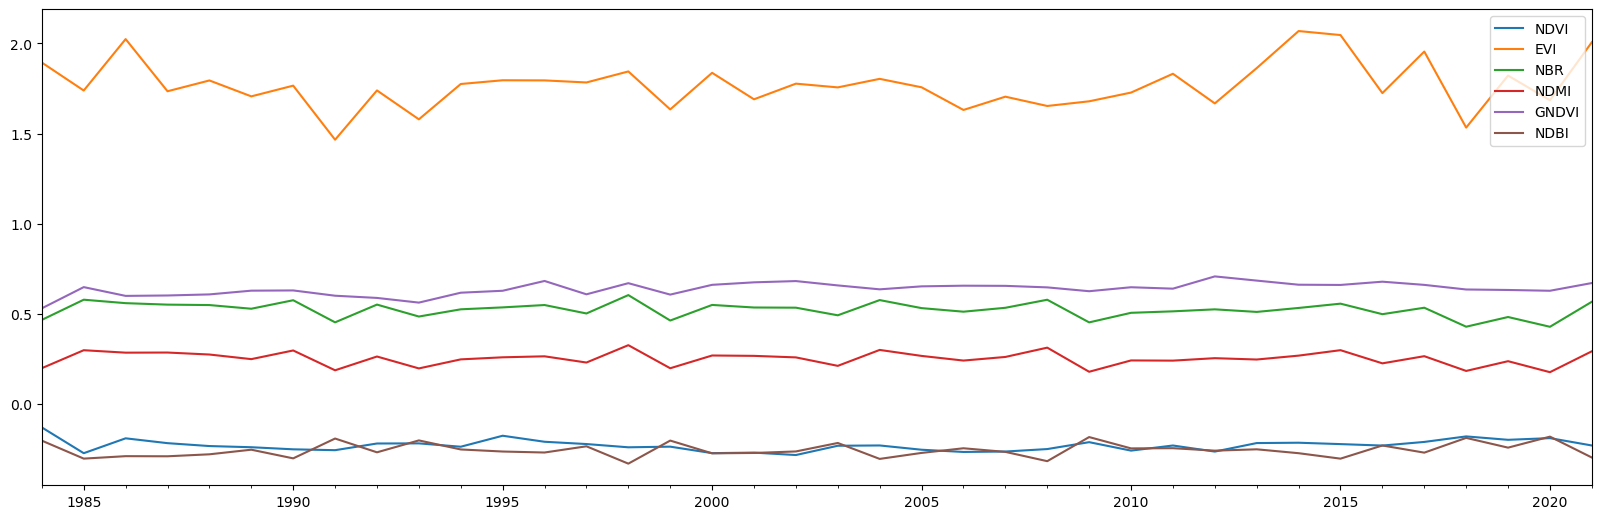

In [31]:
figsize_wide= (20, 6.18)
ax = df_indices.plot(figsize=figsize_wide)
ax.legend()

In [32]:
def plot_keys_matrix(df, title, fignum, label):
    fig = plt.figure(fignum, figsize=(20, 20))
    plt.suptitle(title)

    a = 0

    for row in df_indices.keys():
        for col in df.keys():
            a+=1
            fig.add_subplot(6, 6, a).set_title(f'{row} x {col}')
            plt.scatter(df.loc[:, row], df.loc[:, col], label=label)
            plt.legend()

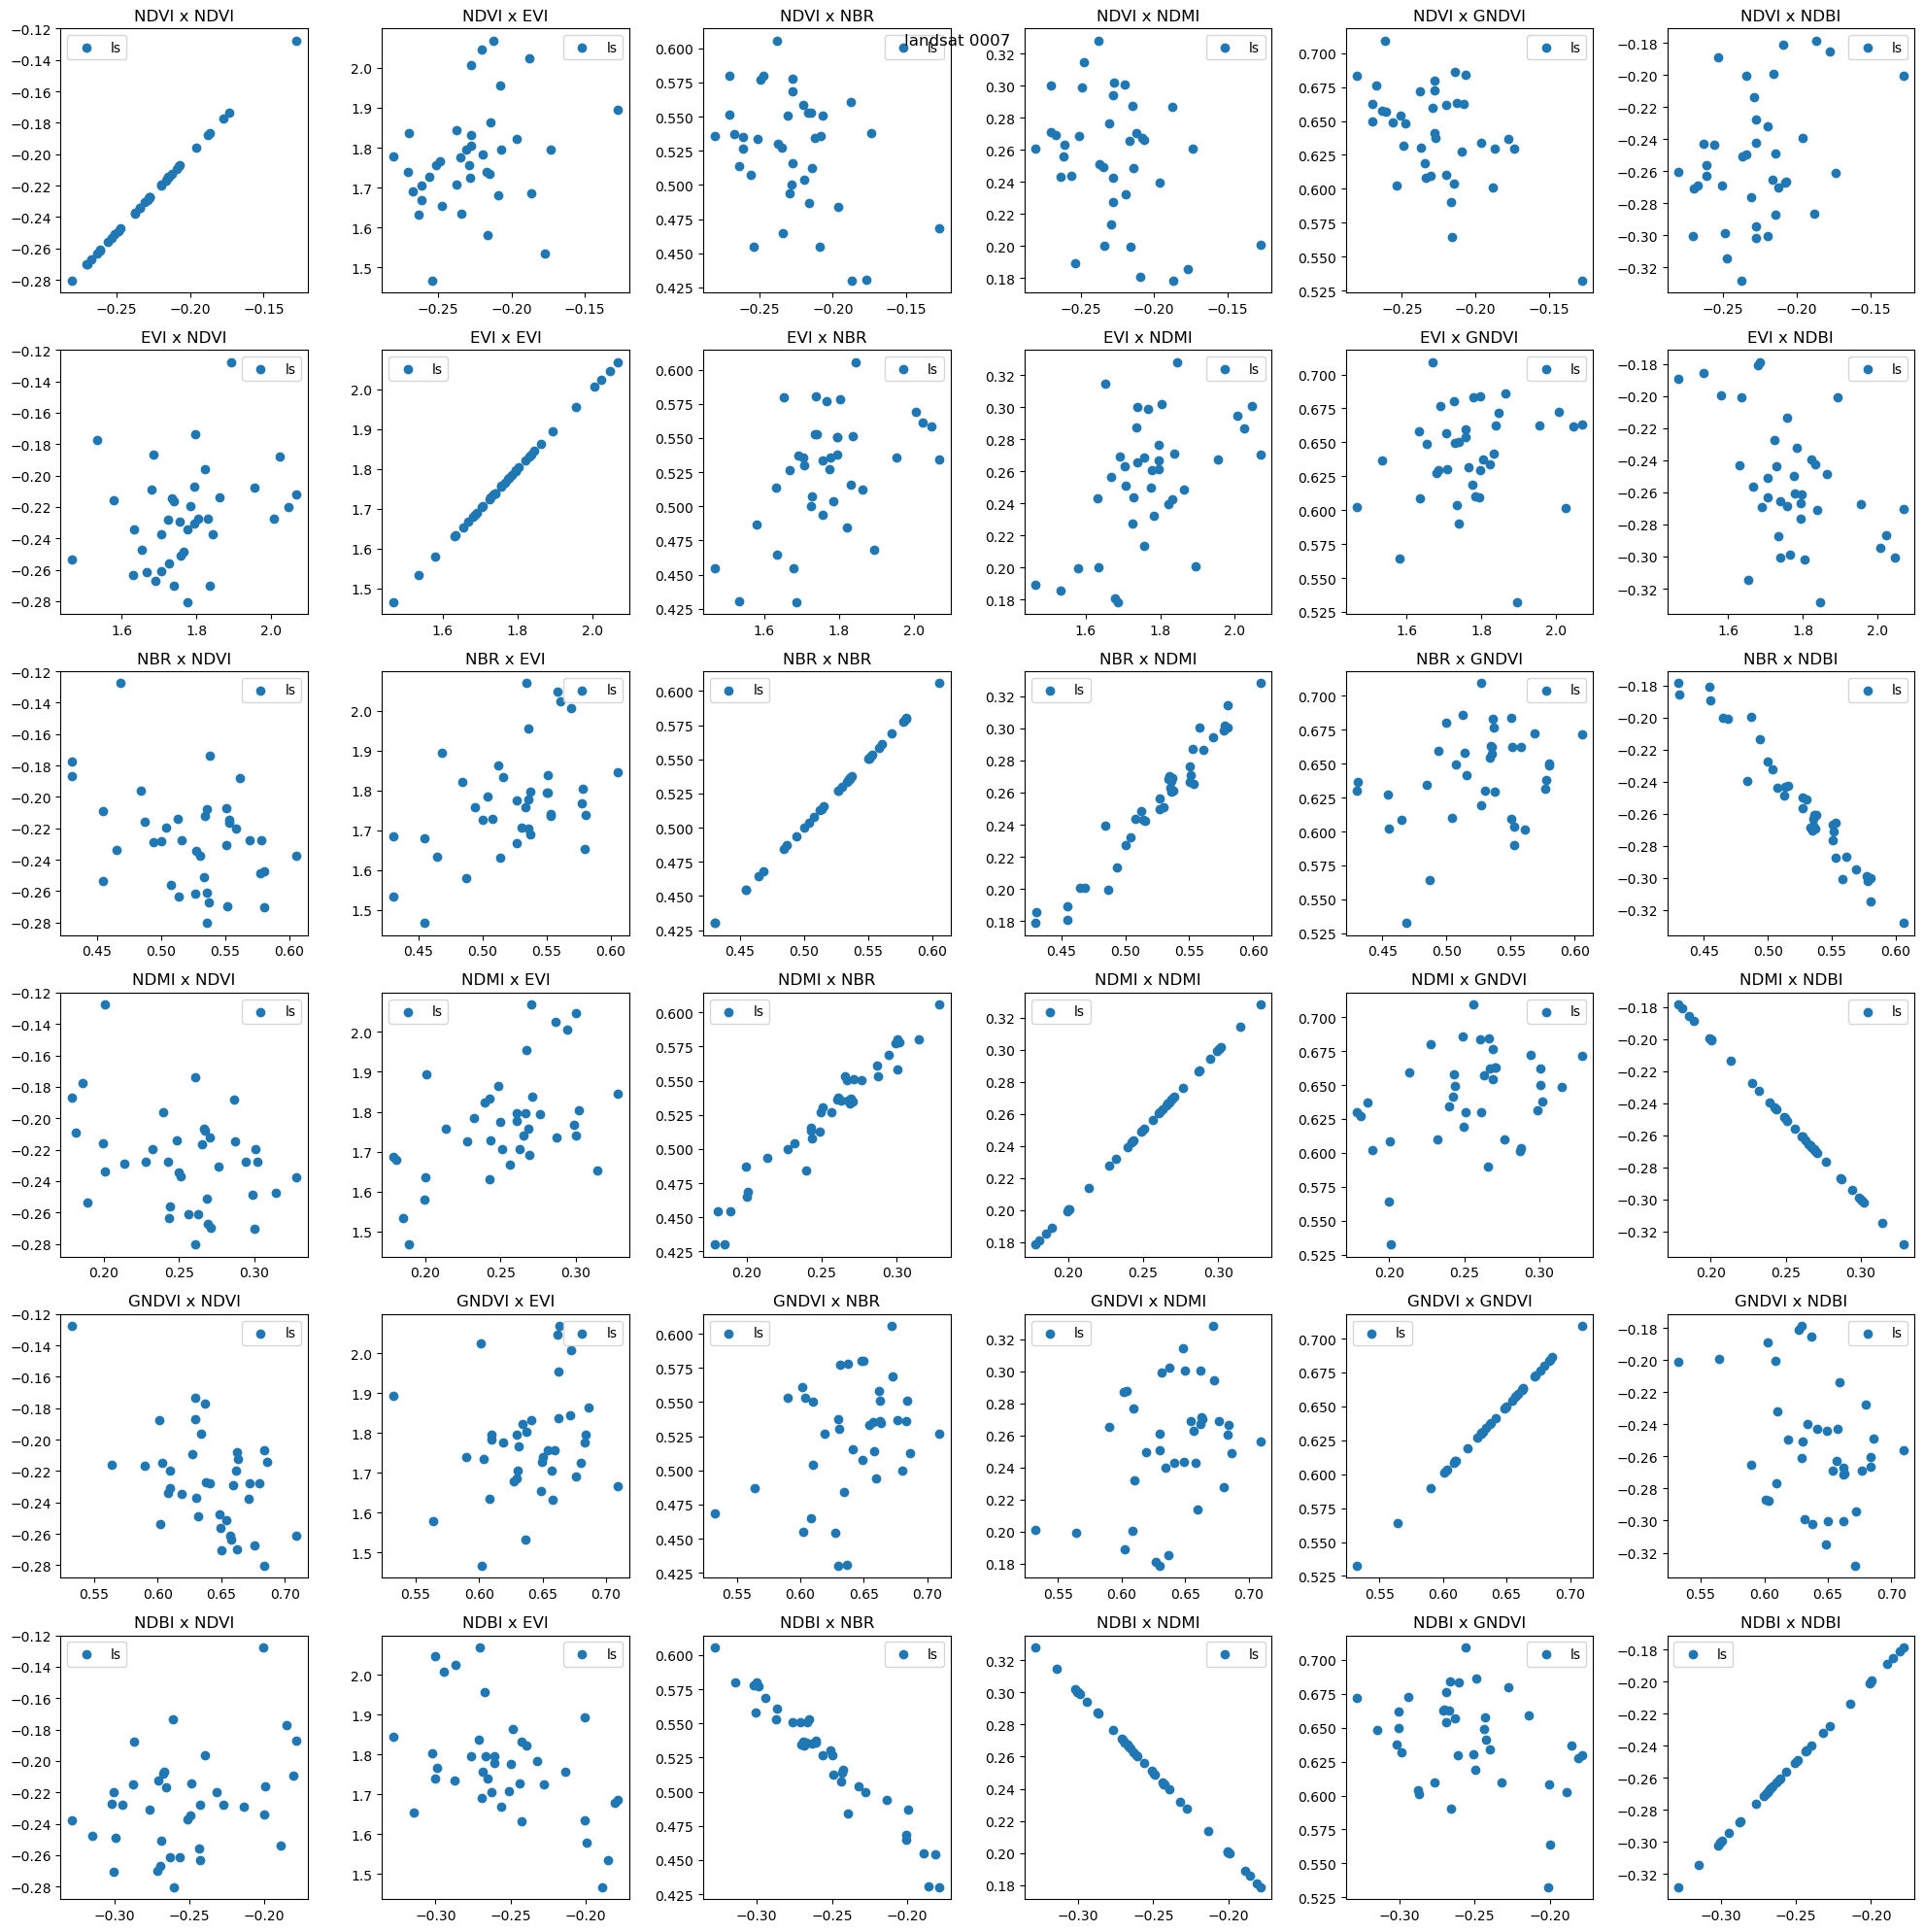

In [33]:
fignum=fignum+1
plot_keys_matrix(df_indices, 'landsat '+ind[16:], fignum, 'ls')
plt.tight_layout()

## Sentinel Control

At this point we have significant detail pertaining to band changes in landsat band values over time. How we might evaluate that is by looking to a similar surface reflectance dataset.

Sentinel 2 data will return *images* with the similar *bands* ... Extracting the band data can be useful in comparing to the landsat to see whether direct band comparison can be made. 

In [72]:
def get_s2_sr_cld_col(aoi, S2_start_year, start_day, S2_end_year, end_day, CLOUD_FILTER):
    
    
    '''
    1. Import and filter S2 SR. 
    2. Separately import the cloud probability as collection
    '''
    
    s2_sr_col = (ee.ImageCollection('COPERNICUS/S2_SR')
        .filterBounds(aoi)
        .filterDate(ee.Date(str(S2_start_year) + "-" + start_day), ee.Date(str(S2_end_year) + "-" + end_day).advance(1, "day"))
        .filter(ee.Filter.lte('CLOUDY_PIXEL_PERCENTAGE', CLOUD_FILTER))
                )

    s2_cloudless_col = (ee.ImageCollection('COPERNICUS/S2_CLOUD_PROBABILITY')
        .filterBounds(aoi)
        .filterDate(ee.Date(str(S2_start_year) + "-" + start_day), ee.Date(str(S2_end_year) + "-" + end_day).advance(1, "day"))
                       )

    # Join the filtered s2cloudless collection to the SR collection by the 'system:index' property.
    return ee.ImageCollection(ee.Join.saveFirst('s2cloudless').apply(**{
        'primary': s2_sr_col,
        'secondary': s2_cloudless_col,
        'condition': ee.Filter.equals(**{
            'leftField': 'system:index',
            'rightField': 'system:index'
        })
    }))


def add_cloud_bands(img):
    # Get s2cloudless image, subset the probability band.
    cld_prb = ee.Image(img.get('s2cloudless')).select('probability')

    # Condition s2cloudless by the probability threshold value.
    is_cloud = cld_prb.gt(CLD_PRB_THRESH).rename('clouds')

    # Add the cloud probability layer and cloud mask as image bands.
    return img.addBands(ee.Image([cld_prb, is_cloud]))


def add_shadow_bands(img):
    # Identify water pixels from the SCL band.
    not_water = img.select('SCL').neq(6)

    # Identify dark NIR pixels that are not water (potential cloud shadow pixels).
    SR_BAND_SCALE = 1e4
    dark_pixels = img.select('B8').lt(NIR_DRK_THRESH*SR_BAND_SCALE).multiply(not_water).rename('dark_pixels')

    # Determine the direction to project cloud shadow from clouds (assumes UTM projection).
    shadow_azimuth = ee.Number(90).subtract(ee.Number(img.get('MEAN_SOLAR_AZIMUTH_ANGLE')));

    # Project shadows from clouds for the distance specified by the CLD_PRJ_DIST input.
    cld_proj = (img.select('clouds').directionalDistanceTransform(shadow_azimuth, CLD_PRJ_DIST*10)
        .reproject(**{'crs': img.select(0).projection(), 'scale': 100})
        .select('distance')
        .mask()
        .rename('cloud_transform'))

    # Identify the intersection of dark pixels with cloud shadow projection.
    shadows = cld_proj.multiply(dark_pixels).rename('shadows')

    # Add dark pixels, cloud projection, and identified shadows as image bands.
    return img.addBands(ee.Image([dark_pixels, cld_proj, shadows]))

def add_cld_shdw_mask(img):
    # Add cloud component bands.
    img_cloud = add_cloud_bands(img)

    # Add cloud shadow component bands.
    img_cloud_shadow = add_shadow_bands(img_cloud)

    # Combine cloud and shadow mask, set cloud and shadow as value 1, else 0.
    is_cld_shdw = img_cloud_shadow.select('clouds').add(img_cloud_shadow.select('shadows')).gt(0)

    # Remove small cloud-shadow patches and dilate remaining pixels by BUFFER input.
    # 20 m scale is for speed, and assumes clouds don't require 10 m precision.
    is_cld_shdw = (is_cld_shdw.focalMin(2).focalMax(BUFFER*2/20)
        .reproject(**{'crs': img.select([0]).projection(), 'scale': 20})
        .rename('cloudmask'))

    # Add the final cloud-shadow mask to the image.
    return img.addBands(is_cld_shdw)

def apply_cld_shdw_mask(img):
    # Subset the cloudmask band and invert it so clouds/shadow are 0, else 1.
    not_cld_shdw = img.select('cloudmask').Not()

    # Subset reflectance bands and update their masks, return the result.
    return img.select('B.*').updateMask(not_cld_shdw)

In [73]:
def add_cloud_bands(img):
    # Get s2cloudless image, subset the probability band.
    cld_prb = ee.Image(img.get('s2cloudless')).select('probability')

    # Condition s2cloudless by the probability threshold value.
    is_cloud = cld_prb.gt(CLD_PRB_THRESH).rename('clouds')

    # Add the cloud probability layer and cloud mask as image bands.
    return img.addBands(ee.Image([cld_prb, is_cloud]))

def maskS2clouds(image: ee.Image) -> ee.Image:
    """Apply a mask to a sentinel image to filter out cloud, snow, and cloud
    shadow pixels."""
    qa_band = image.select("QA60")

    opaque_bit_msk = 1 << 10
    cirrus_bit_msk = 1 << 11

    qa_mask = (
        qa_band.bitwiseAnd(opaque_bit_msk).eq(0)
        .And(qa_band.bitwiseAnd(cirrus_bit_msk).eq(0))
    )

    return image.updateMask(qa_mask).copyProperties(image)

def clip_collection(image: ee.Image)-> ee.Image:
    
    """
    reduce the size of the image colelction to be only pixels relevant to the aoi
    """
    return image.clip(aoi).copyProperties(image)

def reduce_reproject_resample(image: ee.Image)-> ee.Image:
    
    """
    Mapping this function over a collection returns a (currently sentinel) image of resolution 30m to match the 
    """
    
    reprojected_image = image.reproject(**{'crs':crs,  'scale':30})

    reduced_image = reprojected_image.reduceResolution(**{'reducer': ee.Reducer.mean(), 'maxPixels': 1024})
    
    resampled_image = image.resample("bilinear").set("system:time_start", image.get("system:time_start"))

    return resampled_image

def band_matching(image: ee.Image)->ee.Image:
    input_bands=["B2", "B3", "B4", "B8", "B11", "B12"]
    output_bands=["B1", "B2", "B3", "B4", "B5", "B7"]
    return image.select(input_bands, output_bands)



def build_S2_collection(
    aoi: ee.Geometry, S2_start_year: int, start_day: str, S2_end_year: int, end_day: str, CLOUD_FILTER: int
) -> ee.ImageCollection:
    
    """
    Loading an equivalent Sentinel collection for the years overlapping the landsat collection to get band error estimates;
    <<Written>>
    - maskS2Clouds: using bitshifting to mask the clouds based on the QA band. Not perfect apparently. 
    - clip_collection: reduce the collection size to images relevant to the aoi only
    - reduce_reproject_resample: takes each image in the collection and resamples to match the scale and projection of the landsat collection
    - 
    """
    
    collection = (
        ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
        .filterBounds(aoi)
        .filterDate(ee.Date(str(S2_start_year) + "-" + start_day), ee.Date(str(S2_end_year) + "-" + end_day).advance(1, "day"))
        .filter(ee.Filter.lte('CLOUDY_PIXEL_PERCENTAGE', CLOUD_FILTER))
        .map(maskS2clouds)
        .map(clip_collection)
        .map(reduce_reproject_resample)
        .map(band_matching),
    )
    
    return collection

def build_S2_cloudless_collection(
    col: ee.ImageCollection,
) -> ee.ImageCollection:
    
    """
    The sentinel collection is 
    - clip_collection: reduce the collection size to images relevant to the aoi only
    - reduce_reproject_resample: takes each image in the collection and resamples to match the scale and projection of the landsat collection
    - 
    """
    
    collection = (col.map(clip_collection)
        .map(reduce_reproject_resample)
        .map(band_matching),
    )
    
    return collection




In [77]:
S2_start_year = 2017
S2_end_year = end_year
CLOUD_FILTER = 20
CLD_PRB_THRESH = 40
NIR_DRK_THRESH = 0.15
CLD_PRJ_DIST = 2
BUFFER = 50





S2_col = build_S2_collection(aoi, S2_start_year, start_day, S2_end_year, end_day, CLOUD_FILTER)[0]

S2_cloudless_col = (get_s2_sr_cld_col(aoi, S2_start_year, start_day, S2_end_year, end_day, CLOUD_FILTER)
                    .map(add_cld_shdw_mask)
                    .map(apply_cld_shdw_mask)
                    .map(clip_collection)
                    .map(band_matching))







In [75]:
Map = geemap.Map()
Map.centerObject(aoi, 12)
Map.addLayer(aoi, {},'aoi')
Map.addLayer(S2_col.first(), RGB_VIS, 'S2')
Map.addLayer(s2_cloudless_col.first(), RGB_VIS, 'S2_cloudless')

Map

Map(center=[50.390241997964694, 5.252806723646078], controls=(WidgetControl(options=['position', 'transparent_…

# At this point

The collection generated using the cloud masking methodology from: https://developers.google.com/earth-engine/tutorials/community/sentinel-2-s2cloudless

the masking methodology should make for more comparable datasets. Not we compute the medoid image per summer season. For 2017 to end 2021, both collections are confirmed to be the sme size, with 248 images qualifying for both collections. 

In [117]:
S2_medoid = _generate_medoid_collection(S2_col, start_day, end_day).select([1, 2, 3, 4, 5, 6], ["B1", "B2", "B3", "B4", "B5", "B7"])
S2_cloudless_medoid = _generate_medoid_collection(S2_cloudless_col, start_day, end_day).select([1, 2, 3, 4, 5, 6], ["B1", "B2", "B3", "B4", "B5", "B7"])

Map.addLayer(S2_medoid, RGB_VIS, 'medoid')
Map.addLayer(S2_cloudless_medoid, RGB_VIS, 'cloudless_medoid')


In [118]:
Map

Map(bottom=88838.0, center=[50.322669179684944, 5.679931640625001], controls=(WidgetControl(options=['position…

In [119]:
chart_ts_region2 = chart.Image.series(**{
    'imageCollection': S2_medoid,
    'reducer': ee.Reducer.median(),
    'region': aoi,
    'scale': 1000,
    'band': 'B1_median',
})

chart_ts_region2.renderWidget(width=800)

HTML(value='<embed src=data:image/svg+xml;charset=utf-8;base64,PD94bWwgdmVyc2lvbj0nMS4wJyBlbmNvZGluZz0ndXRmLTg…

In [120]:
chart_ts_region_cloudless = chart.Image.series(**{
    'imageCollection': S2_cloudless_medoid,
    'reducer': ee.Reducer.median(),
    'region': aoi,
    'scale': 1000,
    'band': 'B1_median',
})

chart_ts_region_cloudless.renderWidget(width=800)

HTML(value='<embed src=data:image/svg+xml;charset=utf-8;base64,PD94bWwgdmVyc2lvbj0nMS4wJyBlbmNvZGluZz0ndXRmLTg…

# Investigating The Difference In Cloud Masking

Since the first round of cloud masking didnt work very well, but a workflow for error estimation was established, then we retain the early attempt to mask and compare the new method for marked improvements. 

In [121]:
df_S2 = chart_ts_region2.dataframe
sentinel2_normalised_difference = ND_to_df(df_S2, list_of_indices)
sentinel_areal_stats_clouds = sentinel2_normalised_difference.iloc[:, :].describe()

In [122]:
df_S2_cloudless = chart_ts_region_cloudless.dataframe
sentinel2_ND_cloudless = ND_to_df(df_S2_cloudless, list_of_indices)
sentinel_areal_stats_cloudless = sentinel2_ND_cloudless.iloc[:, :].describe()

In [144]:
def pandas_rmse(df1, df2):
    rmse_df = ((df1 - df2)**2).mean() ** 0.5
    return rmse_df

* The difference between the 2017 zonal stats and the non masked sentinel imagery
1. The count shows equivalent volume of images are compared
2. Blue band 1 is less reflective in the sentinel, green 2 is more reflective, red 3  is less reflective, NIR 4 is much less reflective

In [123]:
difference_noMask = sentinel_areal_stats_clouds - landsat_areal_stats_2017

In [124]:
difference_noMask

,B1,B2,B3,B4,B5,B7,NDVI,EVI,NBR,NDMI,GNDVI,NDBI
count,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
mean,-35.310386,10.067732,-20.896961,-93.359817,126.599769,154.100046,-0.045090,-0.071044,-0.061497,-0.042320,-0.012376,0.042320
std,14.102319,24.601226,4.759784,18.645705,40.146428,34.009924,0.001679,-0.046434,-0.002911,-0.007478,-0.000293,-0.007478
min,-36.548555,-14.668334,-39.798184,-106.006837,11.216216,76.216743,-0.046871,0.074619,-0.072882,-0.035073,-0.018906,0.034206
25%,-67.429320,-21.184971,-16.980418,-98.292908,136.188358,154.964397,-0.048763,-0.045125,-0.024372,-0.008841,-0.010475,0.072822
50%,-37.000000,30.250000,-2.353998,-122.786885,277.236842,240.749112,-0.042430,-0.114954,-0.071713,-0.060660,-0.004579,0.060660
75%,-23.174056,19.607651,-7.352204,-84.000000,99.000000,121.056452,-0.041593,-0.245701,-0.086405,-0.072822,-0.010807,0.008841
max,-12.400000,36.334315,-38.000000,-55.712454,109.357430,177.513527,-0.045791,-0.024060,-0.052115,-0.034206,-0.017115,0.035073


In [145]:
rmse_noMask = pandas_rmse(sentinel2_normalised_difference, landsat_2017)
rmse_noMask

B1        40.330403
B2        29.210163
B3        41.670723
B4       169.762971
B5       161.814748
B7       164.308244
NDVI       0.046232
EVI        0.141412
NBR        0.065162
NDMI       0.048374
GNDVI      0.013979
NDBI       0.048374
dtype: float64

In [146]:
rmse_noMask = pandas_rmse(landsat_2017, sentinel2_normalised_difference)
rmse_noMask

B1        40.330403
B2        29.210163
B3        41.670723
B4       169.762971
B5       161.814748
B7       164.308244
NDVI       0.046232
EVI        0.141412
NBR        0.065162
NDMI       0.048374
GNDVI      0.013979
NDBI       0.048374
dtype: float64

In [125]:
difference_Mask = sentinel_areal_stats_cloudless - landsat_areal_stats_2017

In [126]:
difference_Mask

,B1,B2,B3,B4,B5,B7,NDVI,EVI,NBR,NDMI,GNDVI,NDBI
count,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
mean,-46.056130,1.033604,-36.456801,-129.736032,103.044994,126.437611,-0.051234,-0.064497,-0.057202,-0.042279,-0.011790,0.042279
std,19.915711,34.385596,-1.059221,41.225478,57.477479,19.036578,0.001420,-0.075780,-0.015372,-0.012345,0.000153,-0.012345
min,-49.197189,-26.451424,-43.130208,-185.246361,-26.050279,72.095446,-0.047366,0.081430,-0.053725,-0.036107,-0.013579,0.049229
25%,-82.502952,-41.184971,-37.920578,-119.855769,81.538406,129.938687,-0.060190,-0.035921,-0.015879,-0.009009,-0.017935,0.060208
50%,-58.847176,10.250000,-10.189139,-173.786885,244.236842,206.348576,-0.052807,-0.095627,-0.068305,-0.056842,0.001655,0.056842
75%,-35.666667,9.471083,-21.544081,-106.000000,111.000000,104.158724,-0.043718,-0.182890,-0.077978,-0.060208,-0.017117,0.009009
max,-4.066667,53.083333,-69.500000,-63.791145,104.500000,119.646623,-0.052089,-0.089478,-0.070123,-0.049229,-0.011973,0.036107


* the difference in masking vs no masking. 

In [127]:
difference_Masking = difference_Mask - difference_noMask

In [128]:
difference_Masking

,B1,B2,B3,B4,B5,B7,NDVI,EVI,NBR,NDMI,GNDVI,NDBI
count,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
mean,-10.745744,-9.034128,-15.559840,-36.376215,-23.554775,-27.662435,-0.006144,0.006547,0.004295,0.000041,0.000586,-0.000041
std,5.813393,9.784370,-5.819004,22.579773,17.331052,-14.973345,-0.000260,-0.029345,-0.012461,-0.004867,0.000446,-0.004867
min,-12.648634,-11.783090,-3.332024,-79.239524,-37.266496,-4.121297,-0.000495,0.006811,0.019157,-0.001034,0.005327,0.015023
25%,-15.073632,-20.000000,-20.940160,-21.562862,-54.649952,-25.025710,-0.011427,0.009205,0.008493,-0.000168,-0.007460,-0.012614
50%,-21.847176,-20.000000,-7.835140,-51.000000,-33.000000,-34.400536,-0.010377,0.019327,0.003407,0.003819,0.006234,-0.003819
75%,-12.492611,-10.136568,-14.191877,-22.000000,12.000000,-16.897727,-0.002125,0.062810,0.008427,0.012614,-0.006311,0.000168
max,8.333333,16.749019,-31.500000,-8.078691,-4.857430,-57.866903,-0.006298,-0.065418,-0.018008,-0.015023,0.005142,0.001034


In [134]:
S2_indices = sentinel2_normalised_difference.iloc[:, -6:]
S2_indices.head()

,NDVI,EVI,NBR,NDMI,GNDVI,NDBI
2017-08-01,-0.256657,1.709611,0.449356,0.194445,0.655438,-0.194445
2018-08-01,-0.238579,1.608559,0.406189,0.178882,0.632253,-0.178882
2019-08-01,-0.228411,1.640429,0.412589,0.176670,0.623666,-0.176670
2020-08-01,-0.223076,1.707149,0.357258,0.143515,0.610854,-0.143515
2021-08-01,-0.274482,1.983058,0.516710,0.260163,0.651551,-0.260163


In [135]:
S2_cld_indices = sentinel2_ND_cloudless.iloc[:, -6:]
S2_cld_indices.head()

,NDVI,EVI,NBR,NDMI,GNDVI,NDBI
2017-08-01,-0.268084,1.726476,0.457783,0.207059,0.660580,-0.207059
2018-08-01,-0.248955,1.649634,0.415996,0.182701,0.638487,-0.182701
2019-08-01,-0.230536,1.772422,0.414682,0.176501,0.616206,-0.176501
2020-08-01,-0.229373,1.615370,0.376415,0.142482,0.616181,-0.142482
2021-08-01,-0.274977,1.917640,0.498702,0.245140,0.645241,-0.245140


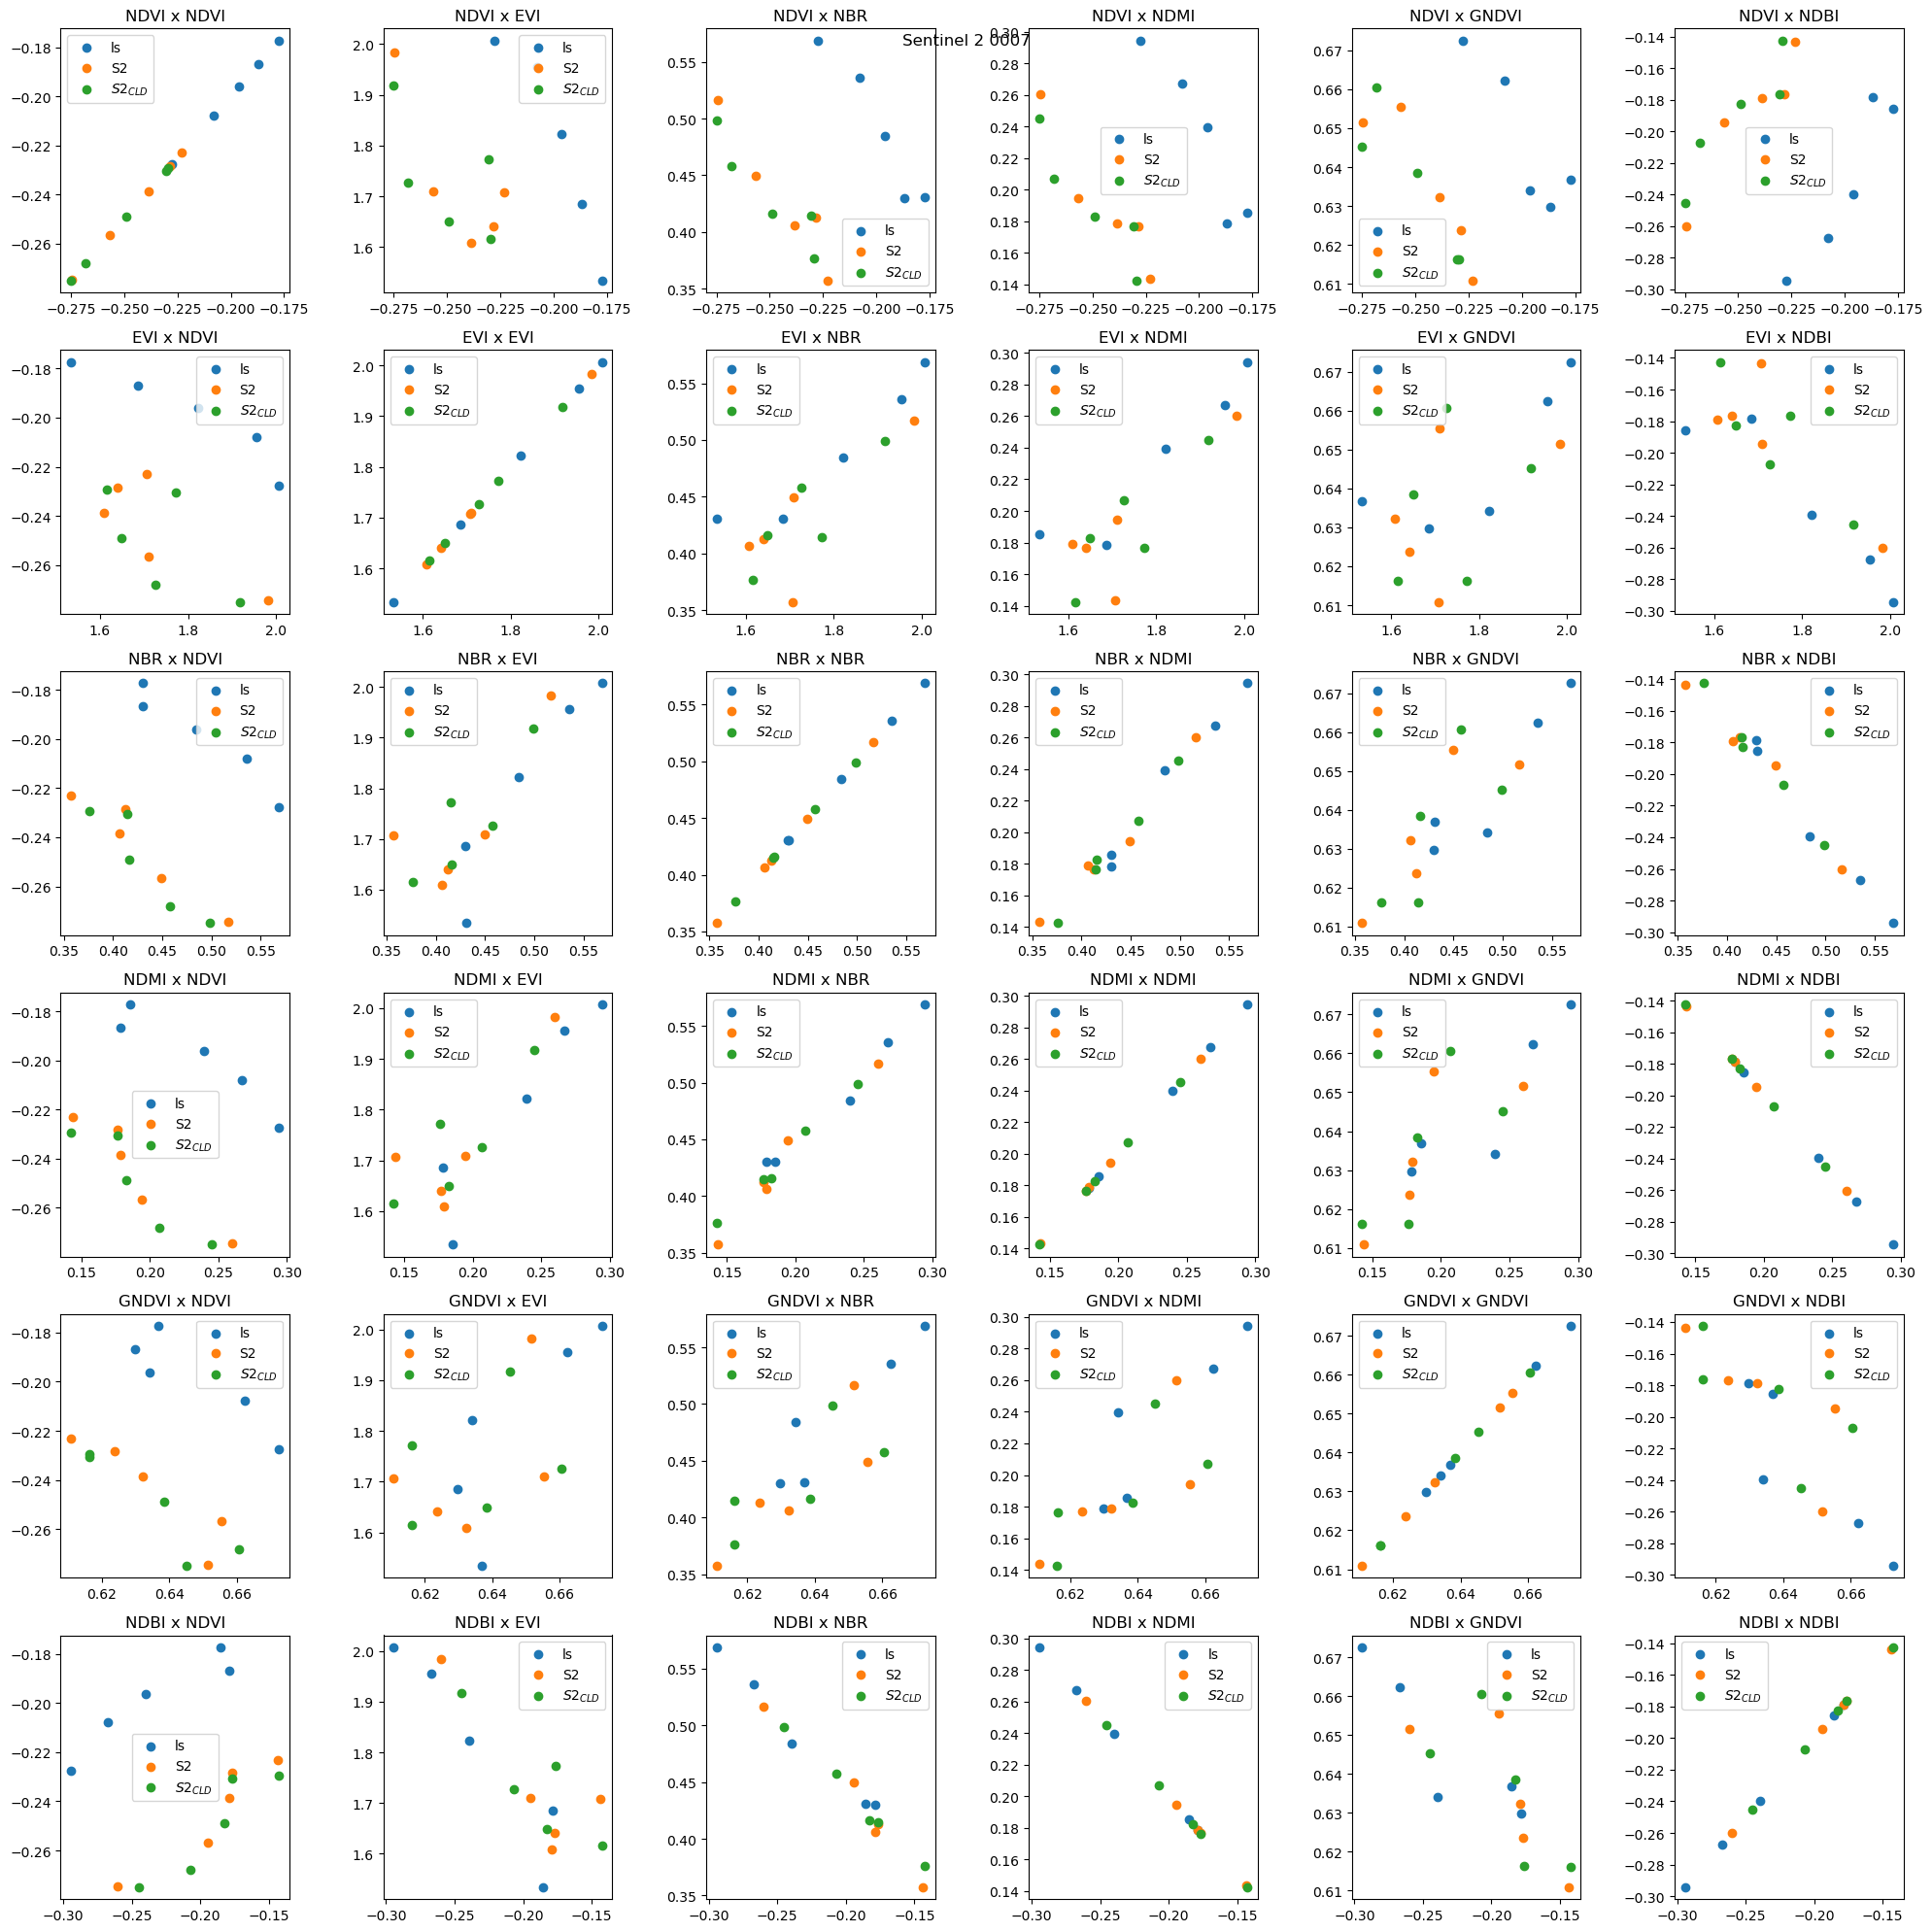

In [141]:
fignum=100
plot_keys_matrix(landsat_2017_indices, 'landsat'+ind[16:], fignum, 'ls')
plot_keys_matrix(S2_indices, 'Sentinel 2 '+ind[16:], fignum, 'S2')
plot_keys_matrix(S2_cld_indices, 'Sentinel 2 '+ind[16:], fignum, '$S2_{CLD}$')
plt.tight_layout()

''

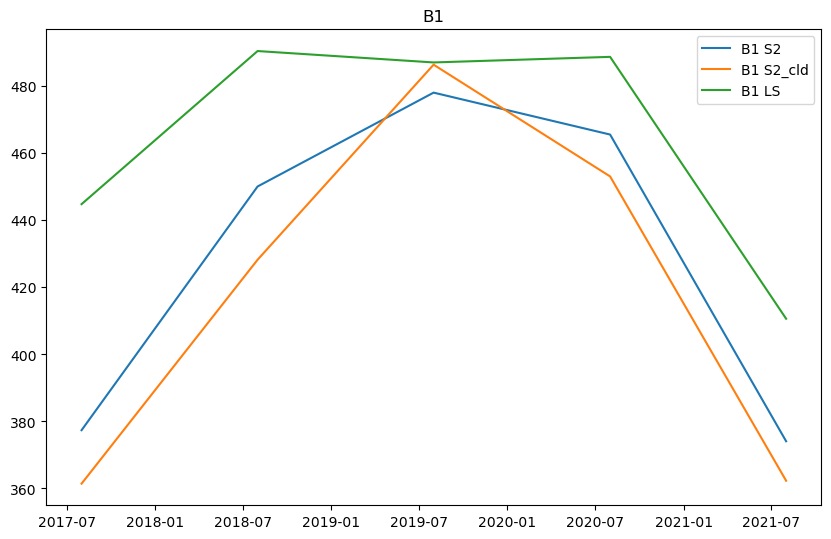

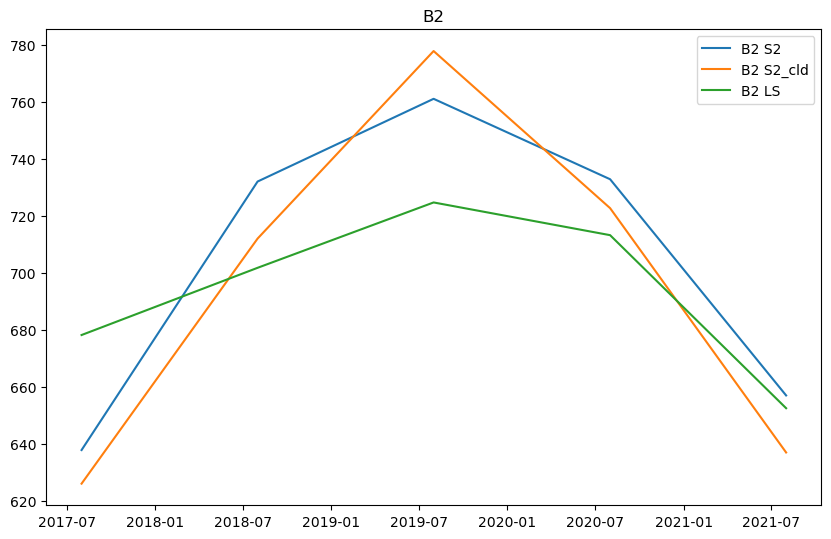

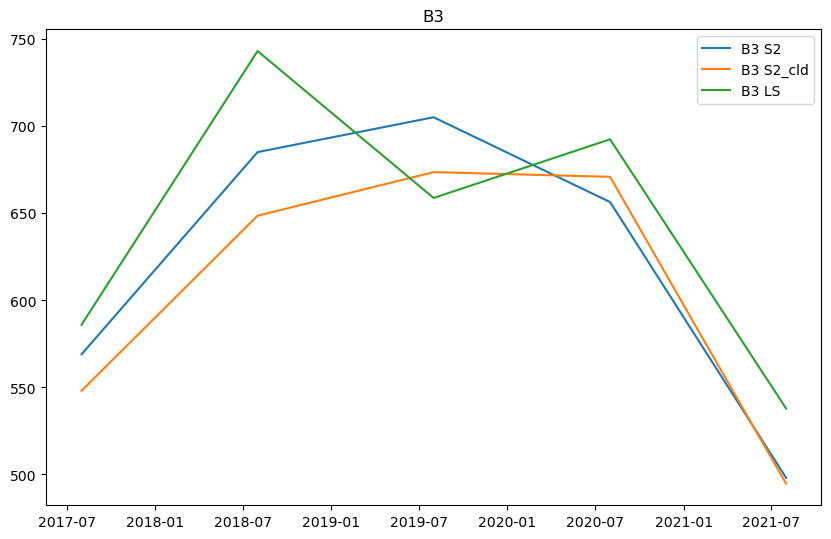

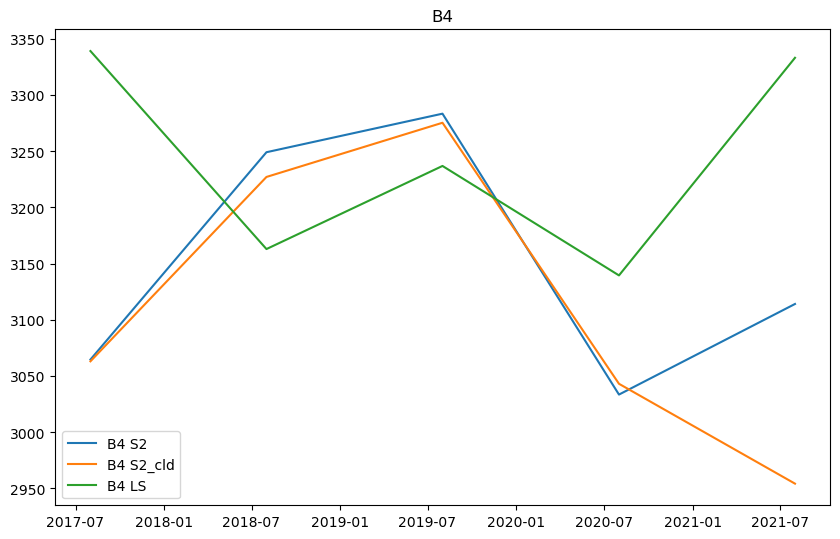

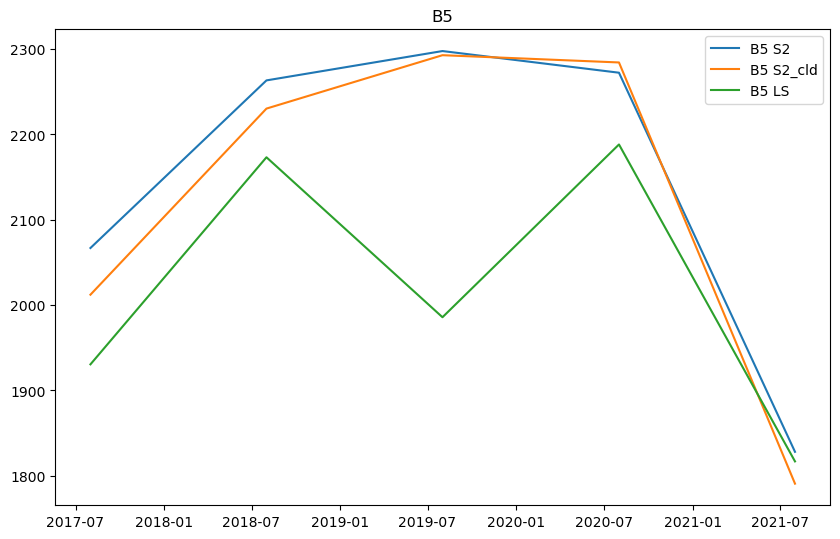

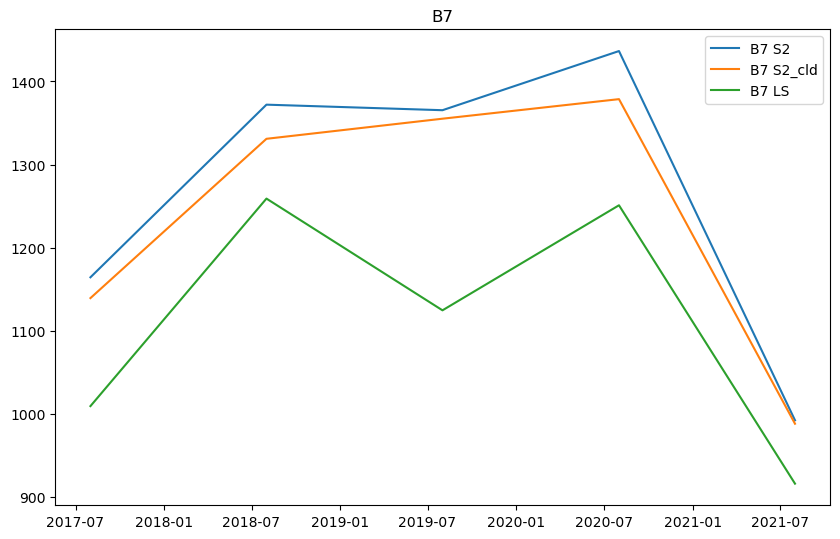

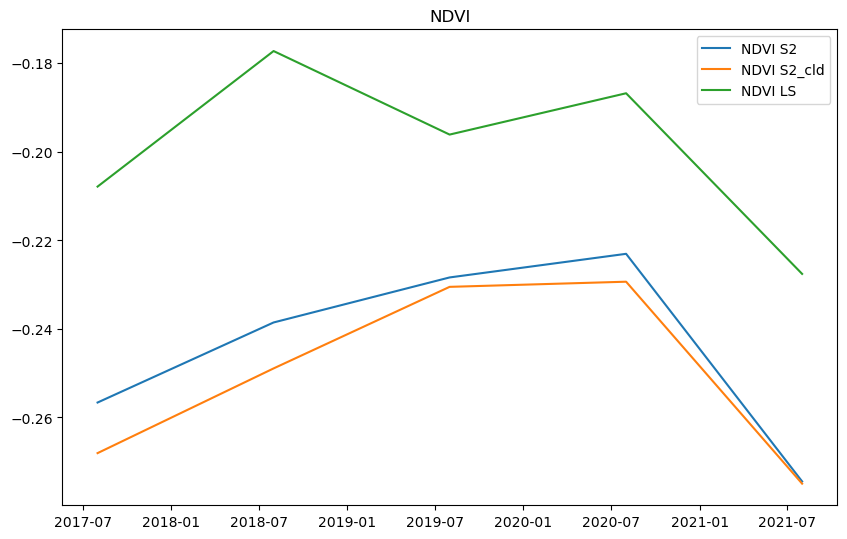

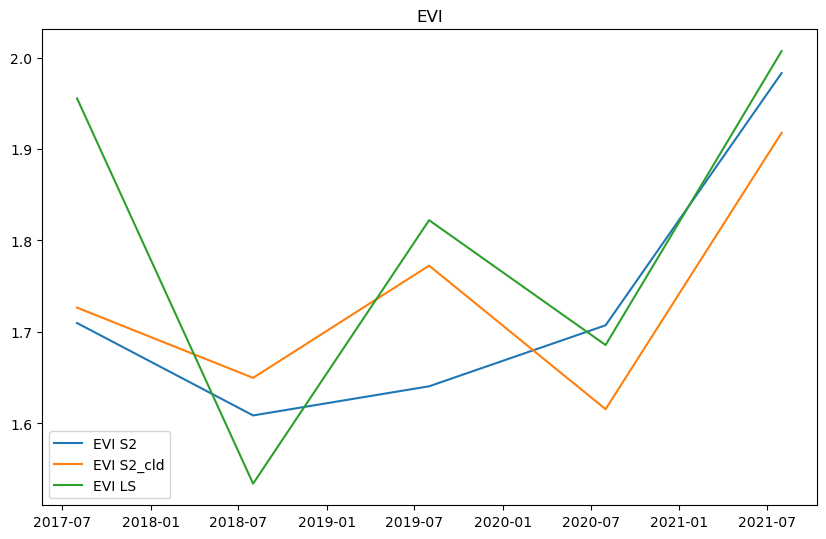

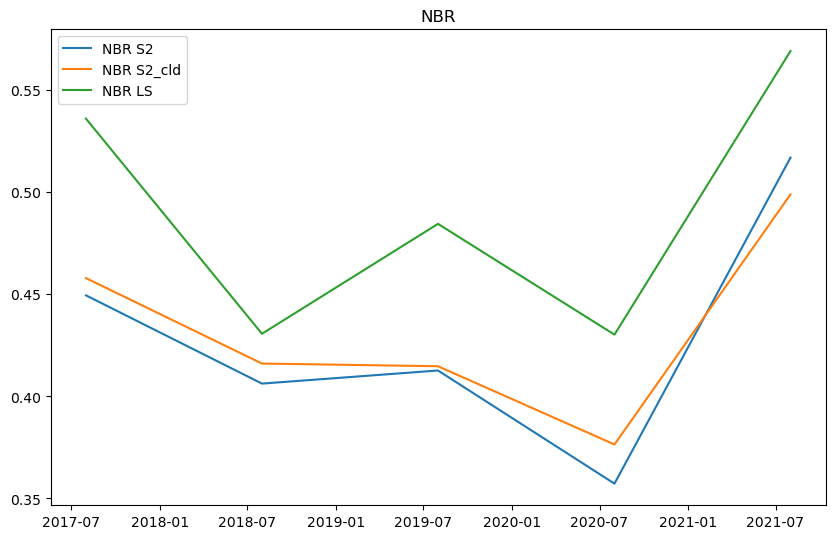

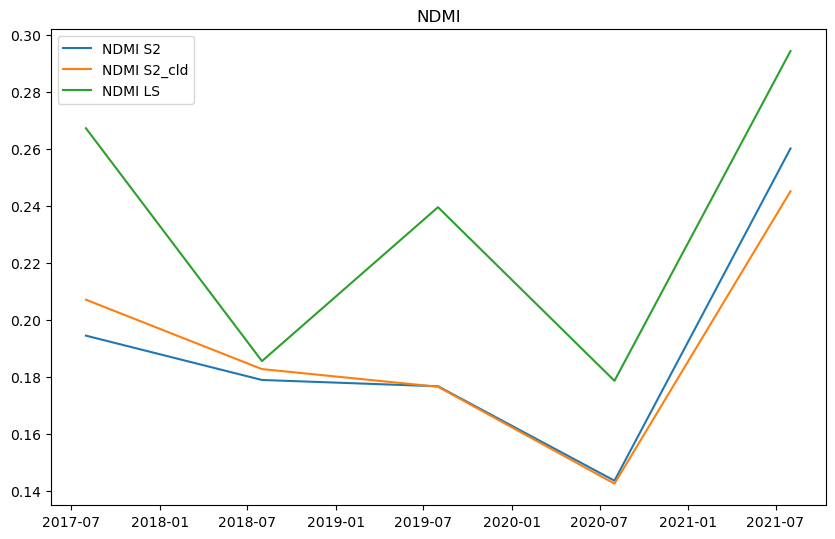

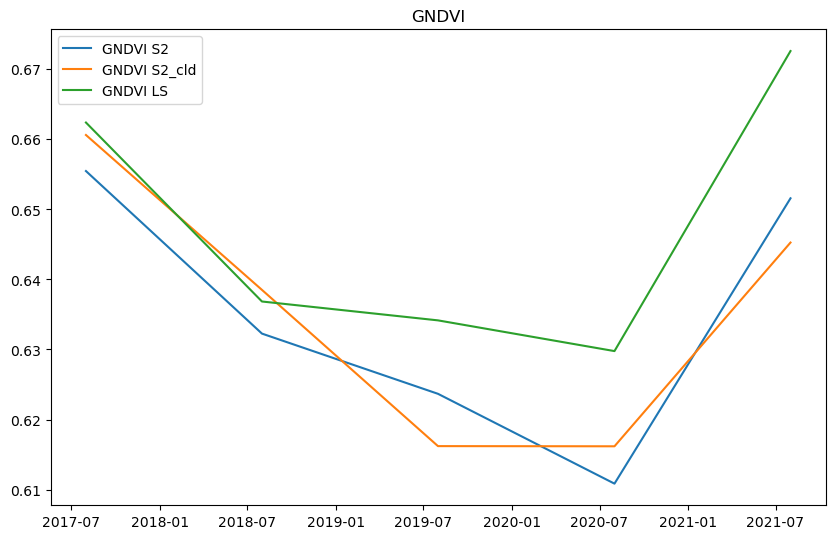

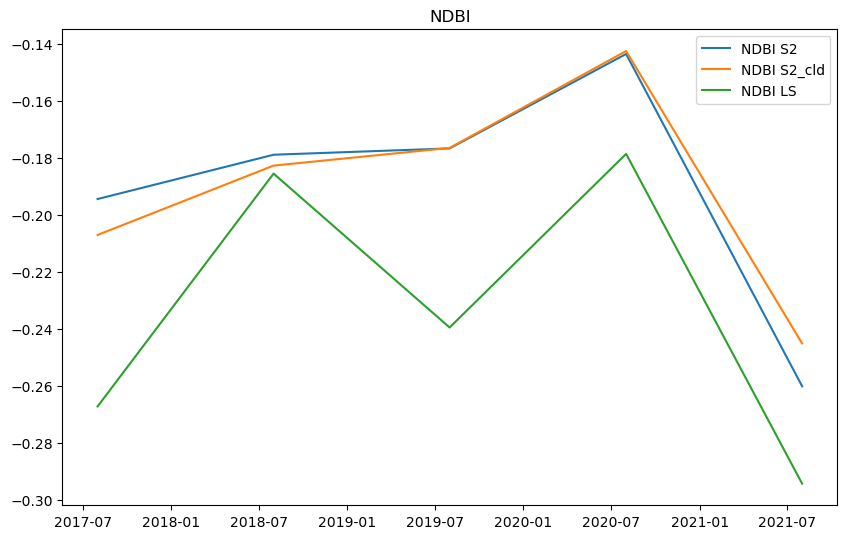

In [143]:
import matplotlib
count = 0
for i in sentinel2_normalised_difference.keys():
    count+=1
    ax = plt.figure(count, figsize=(10, 6.18))
    plt.title(i)
    plt.plot(sentinel2_normalised_difference.loc[:, i], label = i+' S2')
    plt.plot(sentinel2_ND_cloudless.loc[:, i], label = i+' S2_cld')
    plt.plot(landsat_2017.loc[:, i], label = i + ' LS')
    plt.legend()
#ax.set_xticks([S2_indices.index.strftime('%Y') for x in xticks])
plt.xticks()
;
